Mean Squared Error: 22.82965342710061
R-squared Score: 0.5751953294777857


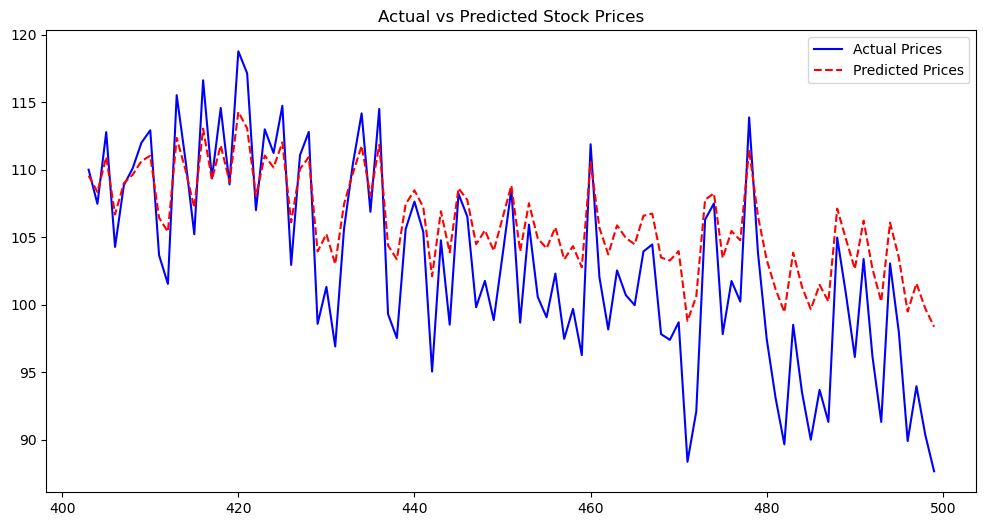

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

# Helper Functions
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, slow=26, fast=12, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    data['Rolling_Mean'] = data['Close'].rolling(window=window).mean()
    data['Rolling_Std'] = data['Close'].rolling(window=window).std()
    data['BB_upper'] = data['Rolling_Mean'] + (data['Rolling_Std'] * num_std)
    data['BB_lower'] = data['Rolling_Mean'] - (data['Rolling_Std'] * num_std)
    return data

def trendline(x, y):
    return np.polyfit(x, y, 1)

# Main code
np.random.seed(42)  # for reproducibility
data = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2022', periods=500),
    'Close': np.random.normal(loc=100, scale=5, size=500) + np.sin(np.linspace(0, 10, 500)) * 10
})

# Calculate Bollinger Bands
data = calculate_bollinger_bands(data)

# Identify local maxima and minima for trendlines
max_peaks, _ = find_peaks(data['Close'], distance=20)
min_peaks, _ = find_peaks(-data['Close'], distance=20)

# Linear Regression for trendline fitting
upper_trendline = np.poly1d(trendline(max_peaks, data['Close'].iloc[max_peaks]))
lower_trendline = np.poly1d(trendline(min_peaks, data['Close'].iloc[min_peaks]))

# Generate trendlines
data['Upper_Trendline'] = upper_trendline(np.arange(len(data)))
data['Lower_Trendline'] = lower_trendline(np.arange(len(data)))

# Feature Engineering
data['Trendline_Deviation'] = (data['Close'] - (data['Upper_Trendline'] + data['Lower_Trendline']) / 2)
data['Volatility'] = data['BB_upper'] - data['BB_lower']
data['RSI'] = calculate_rsi(data['Close'])
data['MACD'], data['Signal_Line'] = calculate_macd(data['Close'])
data['Return'] = data['Close'].pct_change()

# Prepare the dataset
features = ['Trendline_Deviation', 'Volatility', 'RSI', 'MACD', 'Signal_Line', 'Return']
target = 'Close'

X = data[features].dropna()
y = data[target].loc[X.index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection
rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=4)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rfe, y_train)

# ARIMA Model
arima_model = ARIMA(y_train, order=(1,1,1))
arima_results = arima_model.fit()

# Ensemble Prediction
rf_predictions = rf_model.predict(X_test_rfe)
arima_predictions = arima_results.forecast(steps=len(X_test))

ensemble_predictions = (rf_predictions + arima_predictions) / 2

# Evaluate the model
mse = mean_squared_error(y_test, ensemble_predictions)
r2 = r2_score(y_test, ensemble_predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Plotting predicted vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, ensemble_predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()